# MNIST Data Set Analysis Using DNN




### Loading the Libraries


In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

import scipy
from PIL import Image
from scipy import ndimage
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

### Setup the configuration 

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.33

### Loading the input

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist=input_data.read_data_sets('MNIST_data',one_hot=True)

X_train = np.vstack([img.reshape(-1,) for img in mnist.train.images])
y_train = mnist.train.labels

print (y_train.shape[1])
X_test = np.vstack([img.reshape(-1,) for img in mnist.test.images])
y_test = mnist.test.labels

print ("Y_train shape: " + str(y_train.shape))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
10
Y_train shape: (55000, 10)


## Problem 1: Detailed View to MNIST Classification

### 1: Train a fully connected net for MNIST classification

We trained the fully connected network setp by step. First, we need to create the parameters for a fully connected neural network. Teh following fuction initializes the weights and biases using xavier initialization.

In [4]:
def create_params(n_x,n_y, L, hidden_units):
    params=[]
    for i in range(L):
        w_var_name="W"+str(i+1)
        b_var_name="b"+str(i+1)
        n_j= n_y if i==L-1 else hidden_units[i+1]
        n_i= n_x if i==0 else hidden_units[i]
        W=tf.get_variable(w_var_name, [n_i,n_j], initializer = tf.contrib.layers.xavier_initializer())
        b=tf.get_variable(b_var_name, [1,n_j], initializer = tf.zeros_initializer())
        params.append(W)
        params.append(b)
    return params
    

A test function to check the above function.

In [5]:
tf.reset_default_graph()
with tf.Session() as sess:
    params=create_params(784,10,4,[784,1024,1024,1024,10])
    for i in range(4):
        w_var_name="W"+str(i+1)
        b_var_name="b"+str(i+1)
        print(w_var_name+" = " + str(params[2*i]))
        print(b_var_name+ " = " + str(params[2*(i)+1]))
sess.close()

W1 = <tf.Variable 'W1:0' shape=(784, 1024) dtype=float32_ref>
b1 = <tf.Variable 'b1:0' shape=(1, 1024) dtype=float32_ref>
W2 = <tf.Variable 'W2:0' shape=(1024, 1024) dtype=float32_ref>
b2 = <tf.Variable 'b2:0' shape=(1, 1024) dtype=float32_ref>
W3 = <tf.Variable 'W3:0' shape=(1024, 1024) dtype=float32_ref>
b3 = <tf.Variable 'b3:0' shape=(1, 1024) dtype=float32_ref>
W4 = <tf.Variable 'W4:0' shape=(1024, 10) dtype=float32_ref>
b4 = <tf.Variable 'b4:0' shape=(1, 10) dtype=float32_ref>


Next, we implement the feed forward step. Since we need to change the calculation of the last layer later, we did not calculate that in the following function.

In [6]:
def forward_prop(X, params,L):
    A=X
    for i in range(L):
        Z=tf.add(tf.matmul(A,params[2*i]), params[2*i+1])
        if i<L-1:
            A=tf.nn.relu(Z)
    return Z
    

In [7]:
tf.reset_default_graph()

with tf.Session(config=config) as sess:
    x = tf.placeholder(tf.float32, shape=[784,None])
    y_ = tf.placeholder(tf.float32, shape=[10,None])
    params=create_params(784,10,5,[784,1024,1024,1024,10])
    Z=forward_prop(x, params,4)
    print("Z = " + str(Z.shape[1]))
sess.close()

Z = 10


The next function create random batches on the data set. I have adopted this function from Andrew Ng's Deep Learning course. I have completed the specialization online. 

In [8]:
# Copied From Andrew Ng's Deep learning implementation

def create_mini_batches(X,Y, mini_batch_size, seed=0):
    m = X.shape[1]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

Finally, The next method trains the Fully Connected Neural Network Model. The model needs several paramters to run.

In [9]:
def model(X_train, y_train=None, X_test=None, y_test=None, batch_size=64,no_of_epoch=20, no_of_layers=5,hidden_units=None, learning_rate=0.05,activation="relu",ls=0):
    
    tf.reset_default_graph()
    ## Input and output placeholders
    n_x=X_train.shape[1]
    m= X_train.shape[0]
    n_y=y_train.shape[1]
    seed=3
    
    x = tf.placeholder(tf.float32, shape=[None,n_x])
    y = tf.placeholder(tf.float32, shape=[None,n_y])
    
    params=create_params(n_x,n_y,no_of_layers,hidden_units)
    Z=forward_prop(x, params,no_of_layers)
    
   
    if ls==0:
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = Z, labels = y))
    else:
        cost = tf.reduce_mean(tf.losses.mean_squared_error(predictions= Z, labels = y))
    optimizer=tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(cost)
    init = tf.global_variables_initializer()
    
    with tf.Session(config=config) as sess:
        sess.run(init)
        total_batch=int(m / batch_size)
        for epoch in range(no_of_epoch):
            e_cost=0
            seed=seed+1
            minibatches=create_mini_batches(X_train.T,y_train.T, batch_size, seed)
            for mb in minibatches:
                (minibatch_x,minibatch_y)=mb
                _ , c = sess.run([optimizer, cost], feed_dict={x: minibatch_x.T, y: minibatch_y.T})
                e_cost+=c
            if epoch%(no_of_epoch/4)==0:
                print ("Cost at epoch "+ str(epoch)+ " : "+ str(e_cost))
        params=sess.run(params)
        
        
        if X_test is not None:
            correct_prediction = tf.equal(tf.argmax(Z,1), tf.argmax(y,1))

            accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

            print ("Train Accuracy:", accuracy.eval({x: X_train, y: y_train}))


            print ("Test Accuracy:", accuracy.eval({x: X_test, y: y_test}))
    print("Model Trained")

    return params
                
        
    

Now Train the model using MNIST Data set. We were able to achieve 98% accuracy. 

In [10]:
hidden_units=[X_train.shape[1],1024,1024,1024,1024,y_train.shape[1]]
L=5
params=model(X_train,y_train,X_test,y_test,64,20,L,hidden_units,0.05)

Cost at epoch 0 : 339.48408891633153
Cost at epoch 5 : 33.54937493207399
Cost at epoch 10 : 5.82871346527827
Cost at epoch 15 : 0.9515403584446176
Train Accuracy: 1.0
Test Accuracy: 0.981
Model Trained


The following function is a helper function to plot 10 x 10 image. 

In [11]:
# Influenced from: https://gist.github.com/EAZYE9000/f5b47b266ce152230945a0b685c25894
def plot_images(images):
    
    # Create figure with 10x10 sub-plots.
    fig, axes = plt.subplots(10,10,figsize=(10,10))
    xlabel = ['True Class: {}'.format(row) for row in range(10)]
    
    fig.subplots_adjust(hspace=0.5, wspace=0.5)
    img_shape = (28,28)
    
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(img_shape), cmap='binary')
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Copied from https://stackoverflow.com/questions/25812255/row-and-column-headers-in-matplotlibs-subplots/25814386
    pad=10
    for ax, row in zip(axes[:,0], xlabel):
        ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')

    fig.tight_layout()
    plt.show()

### 3: Feed Forward on 1000 test samples

We ran a feedforward on 1000 randomly selected data. The output image is shown below. The result seems pretty accurate.  

In [12]:
def predict(X, params, layer, random=False, random_nodes=10):
    x=tf.placeholder("float",[None,X.shape[1]])
    
    z=forward_prop(x,params,layer)
    z=tf.nn.relu(z)
    y=tf.nn.softmax(z)
    
    sess=tf.Session(config=config)
    if random:
        prediction=sess.run(y,feed_dict={x:X})
        #print(y.shape[1])
        y=prediction[:,np.random.randint(y.shape[1],size=random_nodes)]

    maxp=tf.reduce_max(y,1)
    p=tf.argmax(y,1)
    
    prediction,prob=sess.run([p,maxp],feed_dict={x:X})
    p_pr=list(zip(range(X.shape[0]),prediction,prob))
    p_pr.sort(key=lambda k: (k[2]), reverse=True)
    #print(p_pr)
    return np.array(p_pr)

In [13]:
test1000_x,test1000_y=mnist.test.next_batch(1000)

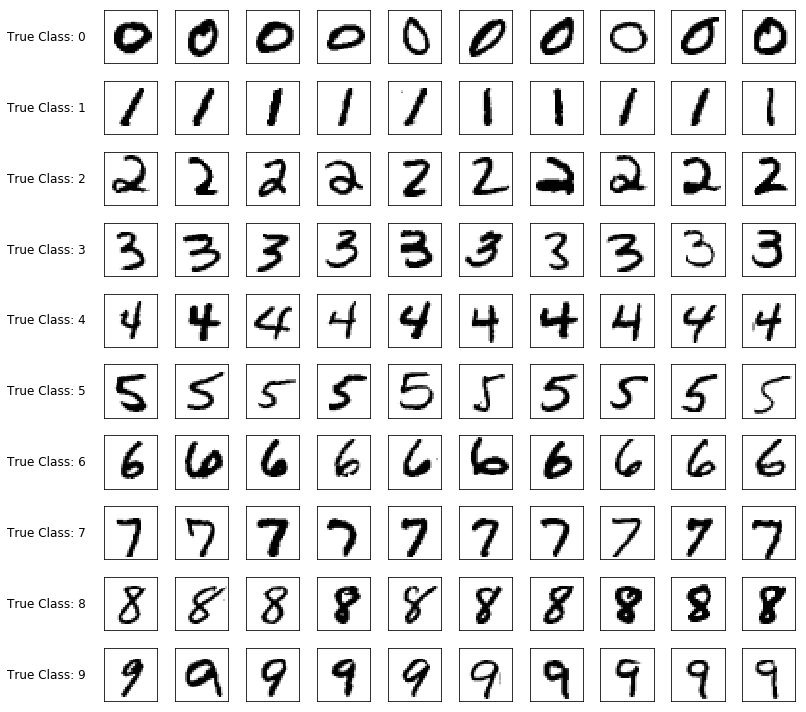

In [14]:
test1000_prediction = predict(test1000_x, params,5)
image_ls=[]

for i in range(10):
    select=np.argwhere(test1000_prediction[:,1]==i)
    t10=[]
    for j in select[0:10]:
        t10.extend(j)
    classes=[]
    for j in (test1000_prediction[t10]):
        classes.append(int(j[0]))
        
    image_ls.extend(classes)
    
plot_images(test1000_x[image_ls,:])


### 4:  Draw second to last layer output

For this part, we randomly selected 10 dimensions out of 1024 dimensions as specified. From the randomly selected outputs we can see that the classes do not have equal number of outputs. This is explainable since, we are randomly selecting 10 out of 1024 and they are probably not favorable to the outputs. We can also see the output is pretty incorrect. In this example, it could not predict any of the correct outputs. This is one of the extreme cases, however, on the separate run we saw some correct labels. However, the second to last layer does not gurantee the correct output. 

On an ideal sitatuation, the output of this layer should give nearly accurate answer. However, if we had lower number of hidden layers, probably it could give nearly accurate answer. However, the accuracy is not guranteed.

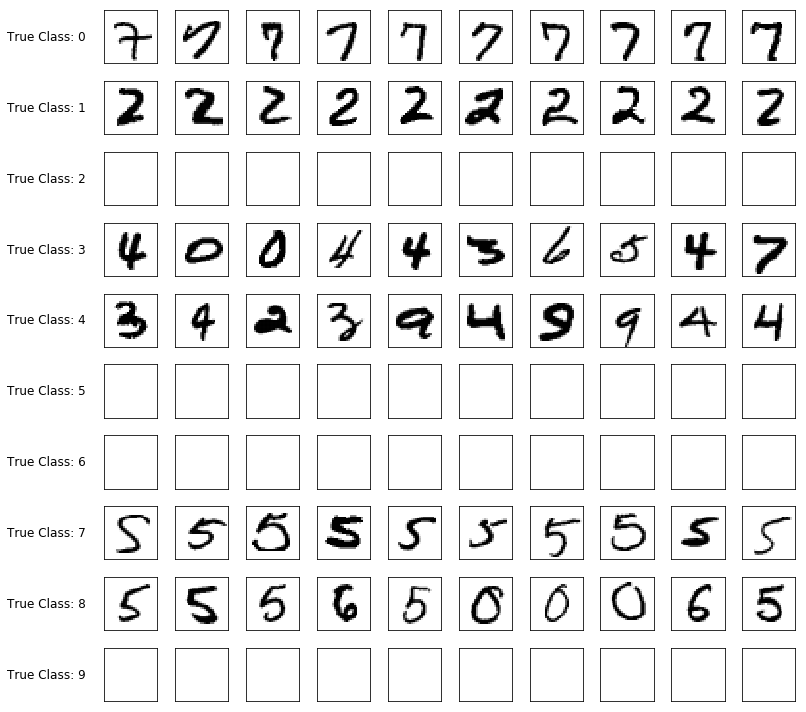

In [15]:
test1000_prediction = predict(test1000_x, params,4,True,10)

fig, axes = plt.subplots(10,10,figsize=(10,10))
xlabel = ['True Class: {}'.format(row) for row in range(10)]
fig.subplots_adjust(hspace=0.5, wspace=0.5)
img_shape = (28,28)

for i in range(10):
    select=np.argwhere(test1000_prediction[:,1]==i)
    t10=[]
    for j in select[0:10]:
        t10.extend(j)
    classes=[]
    for j in range(10-len(t10)):
        t10.append(-1)

    for k,j in enumerate(test1000_prediction[t10]):
        classes.append(int(j[0]))
        if int(t10[k])>=0:  
            axes[i][k].imshow(test1000_x[int(j[0]),:].reshape(img_shape), cmap='binary')
            
        axes[i][k].set_xticks([])
        axes[i][k].set_yticks([])
    
pad=10
for ax, row in zip(axes[:,0], xlabel):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
            xycoords=ax.yaxis.label, textcoords='offset points',
            size='large', ha='right', va='center')

fig.tight_layout()
plt.show()
#plot_images(test1000_x[image_ls,:])

### 6: PCA and tSNE on Input Data

If we look into the scatter plot of PCA, then we can easily observe that there is no sperability among the classes. However, in the tSNE plot we can see some spearability in some classes. However, some classes are so mixed that it might not be possible to classify them by simple classifier or neural network. 

In [16]:
def scatter_plot(X,Y,label_s,title):
    df=np.array(list(zip(pca_trans,y_lab)))
    fig, plot = plt.subplots()
    fig.set_size_inches(10, 10)
    labels=["0","1","2","3","4","5","6","7","8","9"]
    colors=["tomato","green","slateblue","gray","magenta","pink","skyblue","chartreuse","violet","aqua"]
    for i in range(10):
        select=np.where(df[:,1]==i)[0]
        plot.scatter(X[select][:,0], X[select][:,1], c=colors[i], label=labels[i],alpha=0.6,edgecolors=colors[i])

    #plot.scatter(X[:, 0], X[:, 1],c=y_lab)
    plot.set_xticks(())
    plot.set_yticks(())
    plt.ylabel(label_s+"-"+str(2))
    plt.xlabel(label_s+"-"+str(1))
    plot.legend()
    for i in range(10):
        select=np.where(df[:,1]==i)[0]
        plt.annotate(str(i),xy=(np.average(X[select][:,0]),np.average(X[select][:,1])), color='black', weight='normal',size=10,bbox=dict(boxstyle="circle,pad=.5", fc=colors[i]))
    plt.tight_layout()
    plt.title(title)
    plt.show()
    

In [17]:
normalized_x = test1000_x#StandardScaler().fit_transform(test1000_x)
y_lab=np.where(test1000_y==1)[1]
#print(np.where(test1000_y==1)[1])
pca=PCA(n_components=2)
pca_trans=pca.fit_transform(normalized_x)


tsne = TSNE(n_components = 2, perplexity=40, verbose=2)
tsne_trans=tsne.fit_transform(normalized_x)


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.015s...
[t-SNE] Computed neighbors for 1000 samples in 1.403s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 2.822232
[t-SNE] Computed conditional probabilities in 0.061s
[t-SNE] Iteration 50: error = 66.5258484, gradient norm = 0.2474385 (50 iterations in 1.832s)
[t-SNE] Iteration 100: error = 66.5860596, gradient norm = 0.2484103 (50 iterations in 1.987s)
[t-SNE] Iteration 150: error = 66.5009232, gradient norm = 0.2579224 (50 iterations in 1.937s)
[t-SNE] Iteration 200: error = 66.4979477, gradient norm = 0.2635220 (50 iterations in 1.833s)
[t-SNE] Iteration 250: error = 66.8375702, gradient norm = 0.2472126 (50 iterations in 1.683s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.837570
[t-SNE] Iteration 300: error = 1.3300414, gradient norm = 0.0017035 (50 iterations in 1.505s)
[t-SNE] Iteration 350: error = 1.2046024, gradient norm = 0.0005

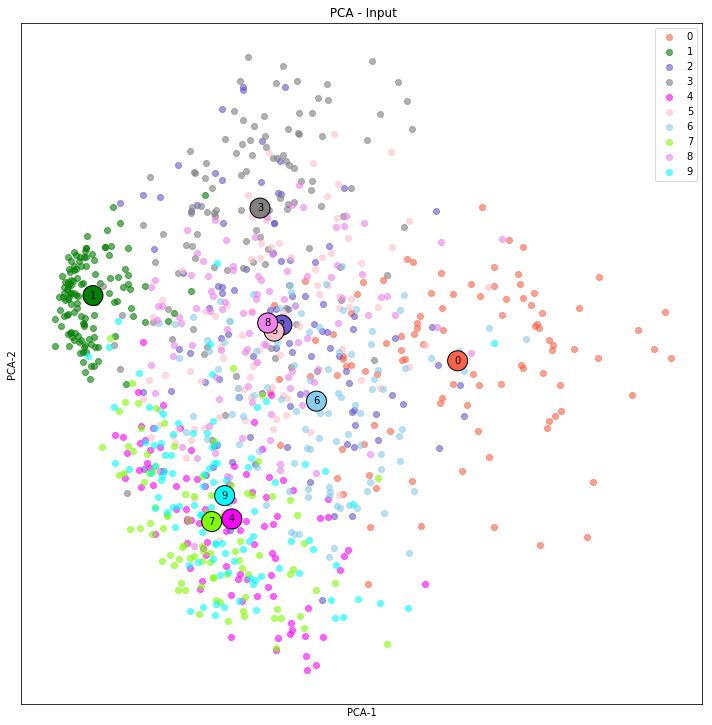

In [18]:
scatter_plot(pca_trans,y_lab,"PCA", " PCA - Input")

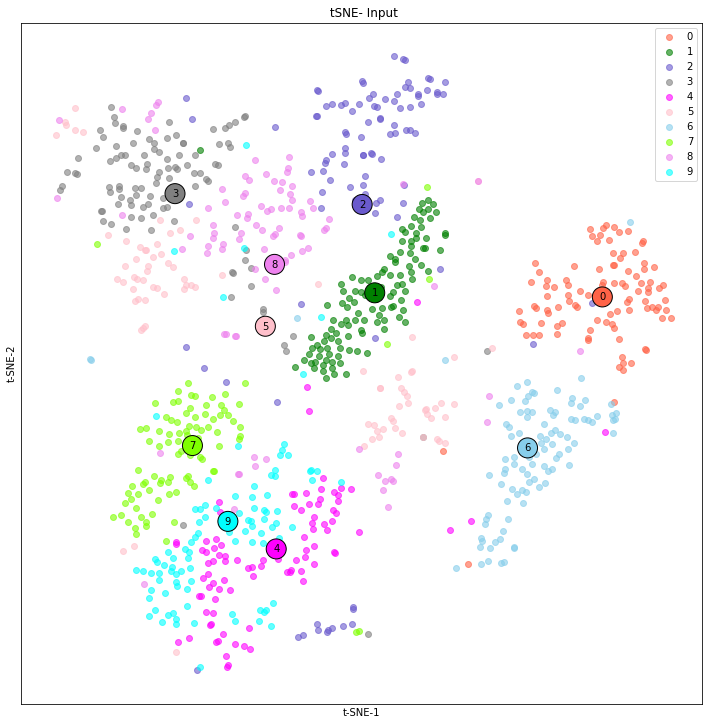

In [19]:
scatter_plot(tsne_trans,y_lab,"t-SNE", " tSNE- Input")

### 7: PCA and tSNE in Layer 1

If we look into the ourput of the first layer, we can see imporvements for both PCA and tSNE. However, PCA is still not clearly separable. However, tSNE keeps improving. Now, PCA is almost separable. However, the later layers could give better results.

In [20]:
def pca_tsne_on_layer(X, params, layer):
    x=tf.placeholder("float",[None,X.shape[1]])
    
    z=forward_prop(x,params,layer)
    y=tf.nn.relu(z)
    
    sess=tf.Session(config=config)

    
    output=sess.run(y,feed_dict={x:X})
    
    normalized_x=output#StandardScaler().fit_transform(test1000_x)
    pca=PCA(n_components=2)
    pca_trans=pca.fit_transform(normalized_x)
    tsne = TSNE(n_components = 2, perplexity=40, verbose=0)
    tsne_trans=tsne.fit_transform(normalized_x)
    return pca_trans,tsne_trans

    

#### Layer 1

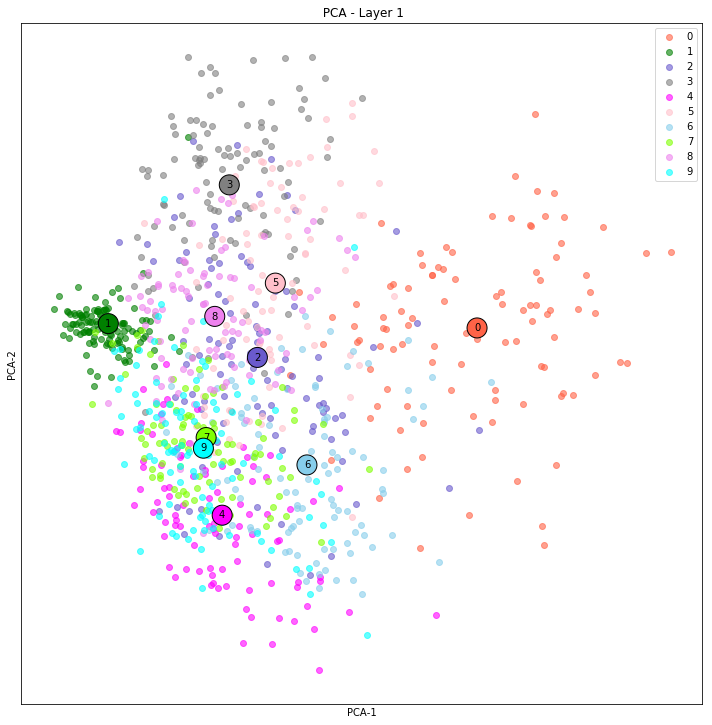

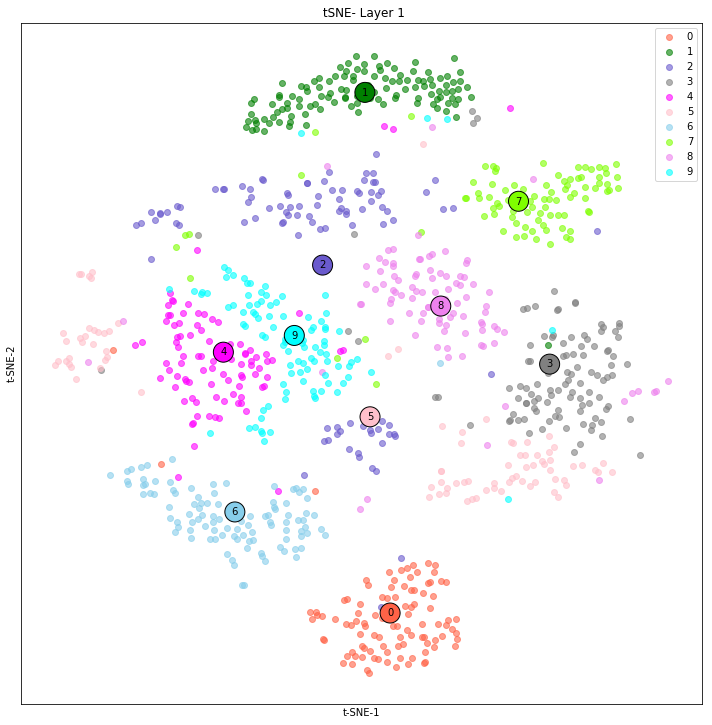

In [21]:
pca_trans,tsne_trans=pca_tsne_on_layer(test1000_x, params, 1)
scatter_plot(pca_trans,y_lab,"PCA", " PCA - Layer 1")
scatter_plot(tsne_trans,y_lab,"t-SNE", " tSNE- Layer 1")
    

### 8: PCA and tSNE for rest of the layers

For the other layers, we can see clear improvements. PCA is not still giving a good representation but tSNE improved a lot and the output from layer 4 and 5 clearly depicts that the classes are separable. We can also notice that the distance among the classes are increaisng by each layer. Therfore, adding more layers is helping the model to learn the data better. The use of tSNE shows that instead of using 784 dimensions, we can easily represent the data using only 2 dimensions which is really resource effective.

#### Layer 2

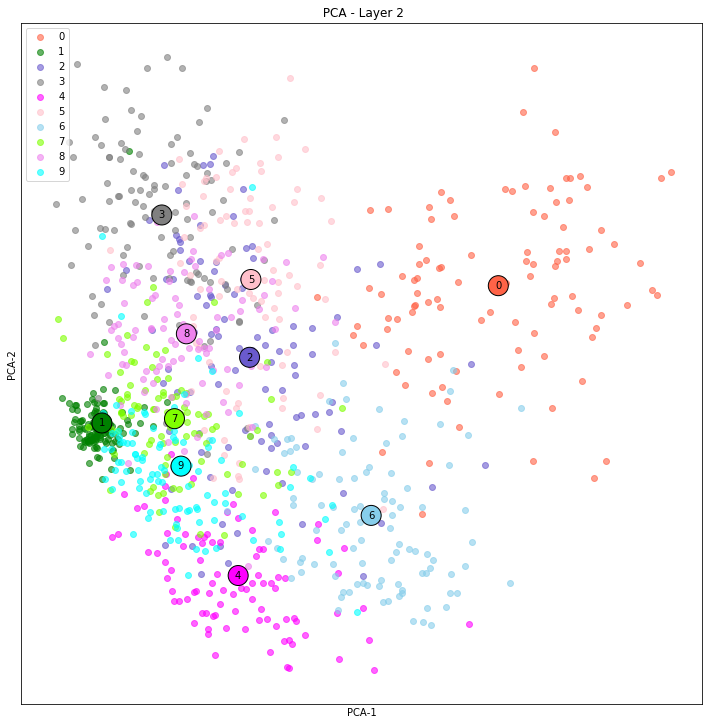

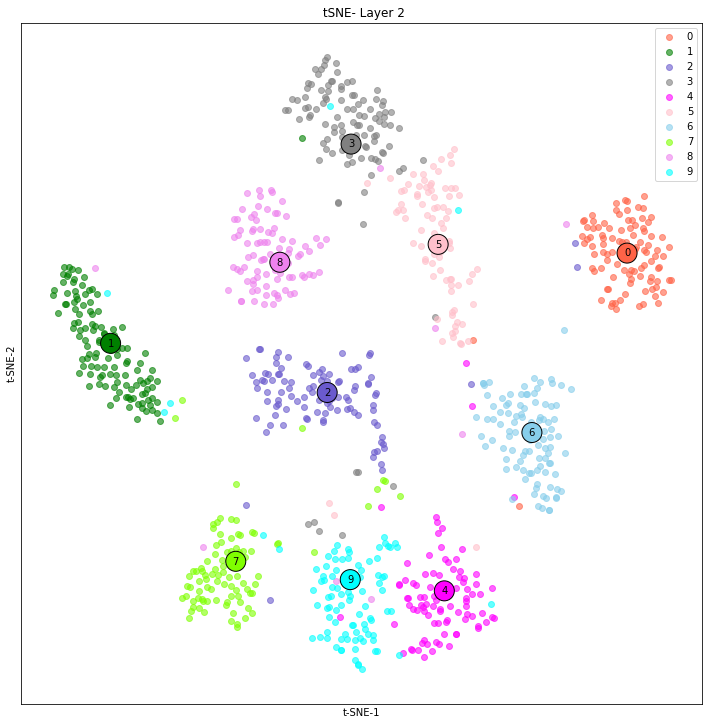

In [22]:
pca_trans,tsne_trans=pca_tsne_on_layer(test1000_x, params, 2)
scatter_plot(pca_trans,y_lab,"PCA", " PCA - Layer 2")
scatter_plot(tsne_trans,y_lab,"t-SNE", " tSNE- Layer 2")

## Layer 3

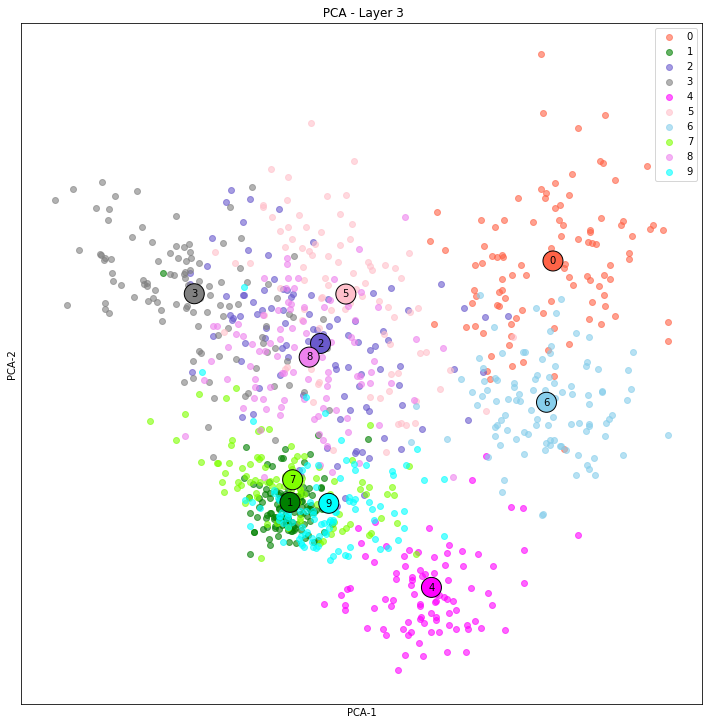

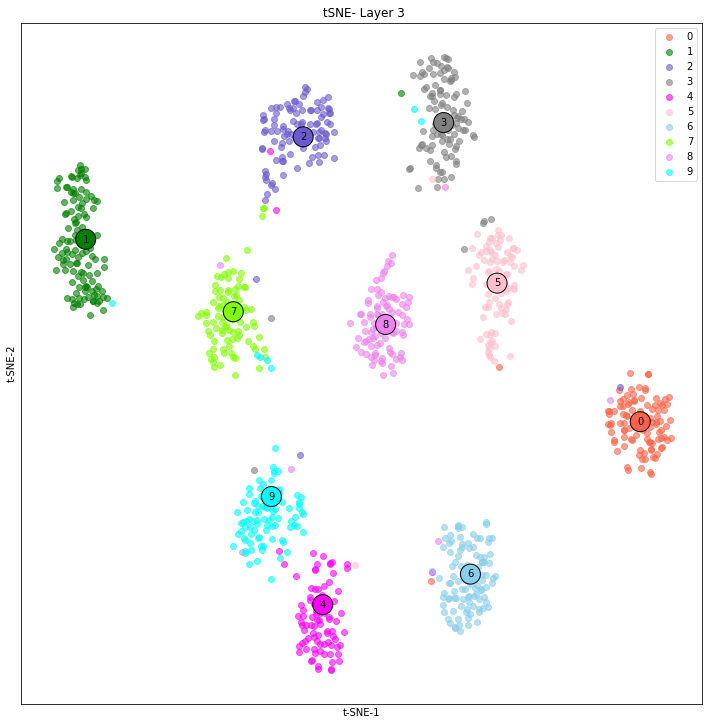

In [23]:
pca_trans,tsne_trans=pca_tsne_on_layer(test1000_x, params,3)
scatter_plot(pca_trans,y_lab,"PCA", " PCA - Layer 3")
scatter_plot(tsne_trans,y_lab,"t-SNE", " tSNE- Layer 3")
    

### Layer 4

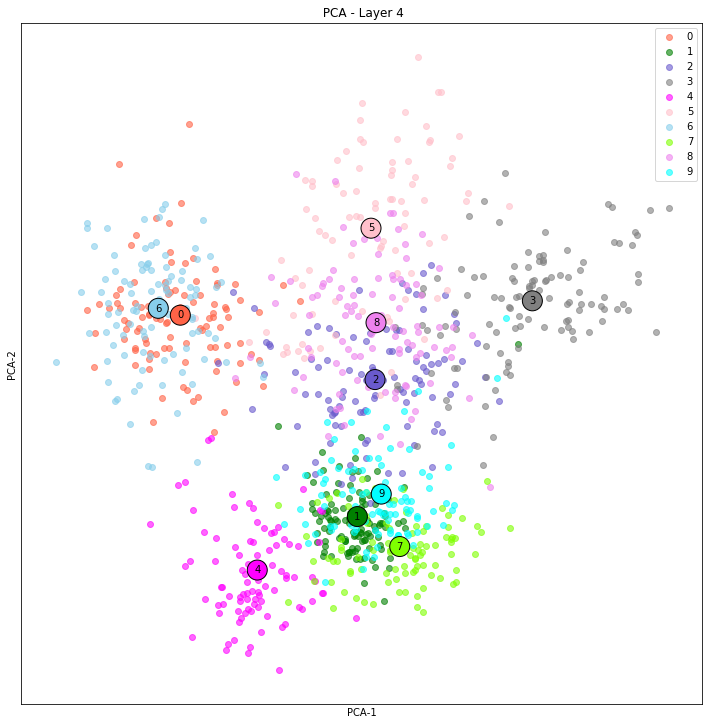

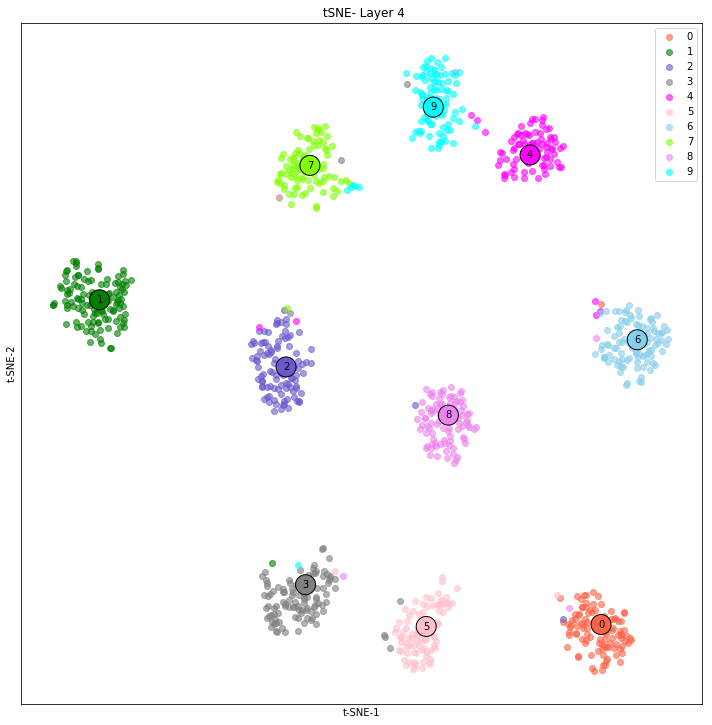

In [24]:
pca_trans,tsne_trans=pca_tsne_on_layer(test1000_x, params,4)
scatter_plot(pca_trans,y_lab,"PCA", " PCA - Layer 4")
scatter_plot(tsne_trans,y_lab,"t-SNE", " tSNE- Layer 4")

### Layer 5

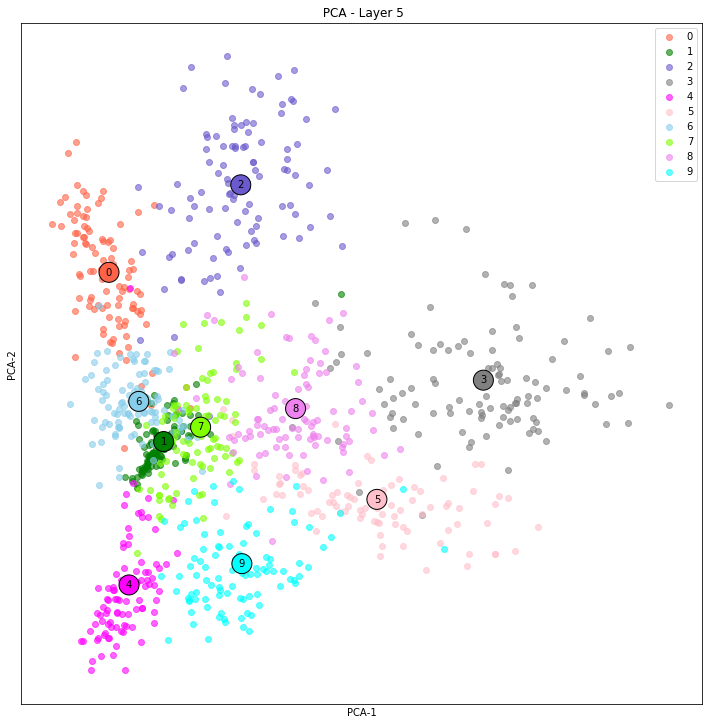

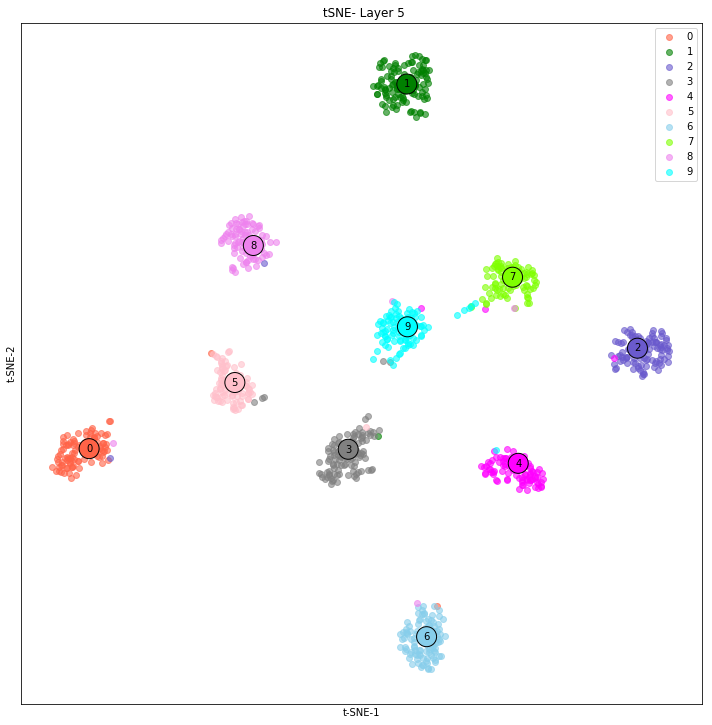

In [25]:
pca_trans,tsne_trans=pca_tsne_on_layer(test1000_x, params,5)
scatter_plot(pca_trans,y_lab,"PCA", " PCA - Layer 5")
scatter_plot(tsne_trans,y_lab,"t-SNE", " tSNE- Layer 5")